In [1]:
# Brightway imports
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import brightway2 as bw

In [2]:
import numpy as np
import pandas as pd

In [3]:
# Custom functions
from useful_functions import get_inventory_dataset, init_simple_lca, multi_lcia
from visualisation_functions import heatmap_lca, heatmap_db_comparison

# Import production data from World Mining Data 2024

In [35]:
file_path = 'data/World_mining_data_2024/6.5. Share_of_World_Mineral_Production_2022_by_Countries.xlsx'  

In [41]:
def get_canada_production_data(file_path):
    """
    Reads an Excel file with multiple sheets, each representing a commodity.
    Extracts Canada's production, world share, and unit for each commodity, returning a DataFrame.
    Commodities are listed in alphabetical order, with 0s for missing data.
    
    Parameters:
    - file_path (str): Path to the Excel file containing the data.
    
    Returns:
    - pd.DataFrame: DataFrame with columns: ['Commodity', 'Production Volume', 'World Share (%)', 'Unit']
    """
    # Load the Excel file
    excel_data = pd.ExcelFile(file_path)
    
    # Initialize a dictionary to store production volume, world share data, and units for Canada
    canada_production_data = {'Commodity': [], 'Production Volume': [], 'World Share (%)': [], 'Unit': []}
    
    # Loop through each sheet, extract Canada's data if present
    for sheet in excel_data.sheet_names:
        df = excel_data.parse(sheet, skiprows=1)  # Start reading from the second row with corrected column headers
        canada_row = df[df['Country'].str.contains("Canada", na=False)]
        
        # Get the unit if present, default to 'tonnes' if not specified
        unit = df['unit'].iloc[0] if 'unit' in df.columns else 'tonnes'
        
        # Add data or fill with 0 if Canada data is missing
        canada_production_data['Commodity'].append(sheet)
        canada_production_data['Unit'].append(unit)
        if not canada_row.empty:
            canada_production_data['Production Volume'].append(float(canada_row['Production 2022'].values[0]))
            canada_production_data['World Share (%)'].append(float(canada_row['Share in %'].values[0]))
        else:
            canada_production_data['Production Volume'].append(0)
            canada_production_data['World Share (%)'].append(0)

    # Convert the dictionary to a DataFrame and sort alphabetically by Commodity
    canada_production_df = pd.DataFrame(canada_production_data).sort_values(by="Commodity").reset_index(drop=True)
    
    return canada_production_df

In [42]:
# We keep only non 0 production volume
canada_production_df = get_canada_production_data(file_path)
canada_production_df = canada_production_df[canada_production_df['Production Volume'] != 0]
canada_production_df

,Commodity,Production Volume,World Share (%),Unit
0,Aluminium,3033966.0,4.408193,metr. t
1,Antimony,2.0,0.002409,metr. t
4,Baryte,50000.0,0.603986,metr. t
10,Cadmium,1800.0,7.825066,metr. t
12,Cobalt,3063.0,1.844847,metr. t
13,Coking Coal,26461240.0,2.539750,metr. t
14,Copper,510782.0,2.298189,metr. t
15,Diamonds (Gem),17728144.0,22.325758,ct
19,Fluorspar,20000.0,0.216534,metr. t
22,Gold,205831.0,6.193863,kg


In [43]:
# We drop the FF and those for which we haven't found LCI 
commodities_to_drop = ['Baryte', 'Coking Coal', 'Diamonds (Gem)', 'Gypsum and Anhydrite', 'Lignite', 
                       'Magnesite', 'Natural Gas', 'Oil Sands (part of Petroleum)', 'Petroleum',
                       'Salt (rock, brines, marine)', 'Steam Coal ', 'Sulfur (elementar & industrial)', 
                       'Talc, Steatite & Pyrophyllite']
canada_production_df = canada_production_df[~canada_production_df['Commodity'].isin(commodities_to_drop)]

In [44]:
canada_production_df

,Commodity,Production Volume,World Share (%),Unit
0,Aluminium,3033966.0,4.408193,metr. t
1,Antimony,2.0,0.002409,metr. t
10,Cadmium,1800.0,7.825066,metr. t
12,Cobalt,3063.0,1.844847,metr. t
14,Copper,510782.0,2.298189,metr. t
19,Fluorspar,20000.0,0.216534,metr. t
22,Gold,205831.0,6.193863,kg
23,Graphite,13000.0,0.752539,metr. t
25,Indium,39.0,3.869048,metr. t
26,Iron (Fe),42073900.0,2.718035,metr. t


In [47]:
# We put everything in kg
canada_production_df_kg = canada_production_df.copy()
canada_production_df_kg.loc[canada_production_df_kg['Unit'] == 'metr. t', 'Production Volume'] *= 1000
canada_production_df_kg.loc[canada_production_df_kg['Unit'] == 'metr. t', 'Unit'] = 'kg'
canada_production_df_kg.rename(columns={'Production Volume': 'Production Volume (kg)'}, inplace=True)
canada_production_df_kg.drop(columns=['Unit'], inplace=True)
canada_production_df_kg

,Commodity,Production Volume (kg),World Share (%)
0,Aluminium,3.033966e+09,4.408193
1,Antimony,2.000000e+03,0.002409
10,Cadmium,1.800000e+06,7.825066
12,Cobalt,3.063000e+06,1.844847
14,Copper,5.107820e+08,2.298189
19,Fluorspar,2.000000e+07,0.216534
22,Gold,2.058310e+05,6.193863
23,Graphite,1.300000e+07,0.752539
25,Indium,3.900000e+04,3.869048
26,Iron (Fe),4.207390e+10,2.718035


# LCA

## Import LCI and LCIA methods

In [10]:
bd.projects.set_current("regioinvent")
bd.databases

Databases dictionary with 9 object(s):
	LIB raw materials
	Regioinvent
	biosphere3
	biosphere3_spatialized_flows
	cobalt
	ecoinvent-3.9.1-cutoff
	ecoinvent-3.9.1-cutoff regionalized
	graphite
	lithium

In [11]:
EI_DB = 'ecoinvent-3.9.1-cutoff'
RI_DB = 'Regioinvent'

In [12]:
# From Ecoinvent
# (mineral name: activity name, reference product, location)
INVENTORIES_EI = {
    "Aluminium": ("market for aluminium, primary, ingot", "aluminium, primary, ingot", "IAI Area, North America"),
    "Antimony": ("market for antimony", "antimony", "GLO"),
    "Cadmium": ("market for cadmium", "cadmium", "GLO"),
    "Cobalt": ("market for cobalt oxide", "cobalt oxide", "GLO"),
    "Copper": ("market for copper, cathode", "copper, cathode", "GLO"),
    "Fluorspar": ("market for fluorspar, 97% purity", "fluorspar, 97% purity", "GLO"),
    "Gold": ("market for gold", "gold", "GLO"),
    "Graphite": ("market for graphite", "graphite", "GLO"),
    "Indium": ("market for indium", "indium", "GLO"),
    "Iron (Fe)": ("market for iron ore, crude ore, 46% Fe", "iron ore, crude ore, 46% Fe", "GLO"),
    "Lead": ("market for lead", "lead", "GLO"),
    "Molybdenum": ("market for molybdenum", "molybdenum", "GLO"),
    "Nickel": ("market for nickel, class 1", "nickel, class 1", "GLO"),
    "Niobium (Nb2O5)": ("market for ferroniobium, 66% Nb", "ferroniobium, 66% Nb", "GLO"),
    "Palladium": ("market for palladium", "palladium", "GLO"),
    "Platinum": ("market for platinum", "platinum", "GLO"),
    "Potash (K2O)": ("market for potash salt", "potash salt", "RoW"),
    "Rhodium": ("market for rhodium", "rhodium", "GLO"),
    "Selenium": ("market for selenium", "selenium", "GLO"),
    "Silver": ("market for silver", "silver", "GLO"),
    "Tellurium": ("market for tellurium, semiconductor-grade", "tellurium, semiconductor-grade", "GLO"),
    "Titanium (TiO2)": ("market for titanium", "titanium", "GLO"),
    "Uranium (U3O8)": ("market for uranium hexafluoride", "uranium hexafluoride", "RoW"),
    "Zinc": ("market for zinc", "zinc", "GLO") 
}

In [13]:
# From Regioinvent
# (mineral name: activity name, reference product, location)
INVENTORIES_RI = {
    "Aluminium": ("consumption market for aluminium, primary, ingot", "aluminium, primary, ingot", "CA"),
    "Antimony": ("consumption market for antimony", "antimony", "CA"),
    "Cadmium": ("consumption market for cadmium", "cadmium", "CA"),
    "Cobalt": ("consumption market for cobalt oxide", "cobalt oxide", "CA"),
    "Copper": ("consumption market for copper, cathode", "copper, cathode", "CA"),
    "Fluorspar": ("consumption market for fluorspar, 97% purity", "fluorspar, 97% purity", "CA"),
    "Gold": ("consumption market for gold", "gold", "CA"),
    "Graphite": ("consumption market for graphite", "graphite", "CA"),
    "Indium": ("consumption market for indium", "indium", "CA"),
    "Iron (Fe)": ("consumption market for iron ore, crude ore, 46% Fe", "iron ore, crude ore, 46% Fe", "CA"),
    "Lead": ("consumption market for lead", "lead", "CA"),
    "Molybdenum": ("consumption market for molybdenum", "molybdenum", "CA"),
    "Nickel": ("consumption market for nickel, class 1", "nickel, class 1", "CA"),
    "Niobium (Nb2O5)": ("consumption market for ferroniobium, 66% Nb", "ferroniobium, 66% Nb", "CA"),
    "Palladium": ("consumption market for palladium", "palladium", "CA"),
    "Platinum": ("consumption market for platinum", "platinum", "CA"),
    "Potash (K2O)": ("consumption market for potash salt", "potash salt", "CA"),
    "Rhodium": ("consumption market for rhodium", "rhodium", "CA"),
    "Selenium": ("consumption market for selenium", "selenium", "CA"),
    "Silver": ("consumption market for silver", "silver", "CA"),
    "Tellurium": ("consumption market for tellurium, semiconductor-grade", "tellurium, semiconductor-grade", "CA"),
    "Titanium (TiO2)": ("consumption market for titanium", "titanium", "CA"),
    "Uranium (U3O8)": ("consumption market for uranium hexafluoride", "uranium hexafluoride", "CA"),
    "Zinc": ("consumption market for zinc", "zinc", "CA") 
}

In [14]:
INVENTORIES_EI_ds = get_inventory_dataset(INVENTORIES_EI, database_names=[EI_DB])

In [15]:
INVENTORIES_RI_ds = get_inventory_dataset(INVENTORIES_RI, database_names=[RI_DB])

In [17]:
# We can also import some from IW+2.1
expert_ei39 = 'data/IW+2.1/impact_world_plus_21_brightway2_expert_version_ei39.6cd1745d7173fc689a3cc8c44fd3e41d.bw2package'
bw.BW2Package.import_file(expert_ei39)

[Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.9: Ecosystem quality: Climate change, ecosystem quality, long term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.9: Ecosystem quality: Climate change, ecosystem quality, short term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.9: Human health: Climate change, human health, long term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.9: Human health: Climate change, human health, short term,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.9: Midpoint: Climate change, long term,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.9: Midpoint: Climate change, short term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.9: Ecosystem quality: Fisheries impact,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.9: Midpoint: Fossil and nuclear energy use,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.9: Midpoint: Fr

In [19]:
IMPACT_METHODS = {
'GWP100': ('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT'),
'Total HH': ('IMPACT World+ Damage 2.1 for ecoinvent v3.9','Human health', 'Total human health'), 
'Total EQ': ('IMPACT World+ Damage 2.1 for ecoinvent v3.9','Ecosystem quality', 'Total ecosystem quality'), 
}

## Perform specific LCA 

## With EI_DB

In [20]:
# Initialize LCA object
lca_ei = init_simple_lca(INVENTORIES_EI_ds["Aluminium"])

In [21]:
specific_lca_ei = {}
for rm in INVENTORIES_EI_ds:
    impacts = multi_lcia(lca_ei, INVENTORIES_EI_ds[rm], IMPACT_METHODS)
    specific_lca_ei[rm] = impacts

specific_lca_ei = pd.DataFrame(specific_lca_ei).T
specific_lca_ei = specific_lca_ei.reset_index().rename(columns={
    'index': 'Commodity',
})

In [22]:
specific_lca_ei

,Commodity,GWP100 (kg CO2-Eq),Total HH (DALY),Total EQ (PDF.m2.yr)
0,Aluminium,10.904943,1.196474e-04,10.742796
1,Antimony,23.206656,1.622316e-03,129.966581
2,Cadmium,3.905355,6.651973e-05,5.171900
3,Cobalt,33.022767,6.089551e-04,38.463718
4,Copper,6.864497,2.832634e-04,50.940743
5,Fluorspar,0.207836,2.083047e-06,0.243093
6,Gold,48449.333560,5.036223e-01,91517.346667
7,Graphite,0.071799,6.041102e-07,0.079770
8,Indium,116.257046,1.979838e-03,155.761997
9,Iron (Fe),0.008887,1.173908e-07,0.053085


## With Regioinvent

In [23]:
# Initialize LCA object
lca_ri = init_simple_lca(INVENTORIES_RI_ds["Aluminium"])

In [24]:
specific_lca_ri = {}
for rm in INVENTORIES_RI_ds:
    impacts = multi_lcia(lca_ri, INVENTORIES_RI_ds[rm], IMPACT_METHODS)
    specific_lca_ri[rm] = impacts

specific_lca_ri = pd.DataFrame(specific_lca_ri).T
specific_lca_ri = specific_lca_ri.reset_index().rename(columns={
    'index': 'Commodity',
})

In [25]:
specific_lca_ri

,Commodity,GWP100 (kg CO2-Eq),Total HH (DALY),Total EQ (PDF.m2.yr)
0,Aluminium,9.244223,8.812850e-05,6.467515
1,Antimony,18.974846,1.557415e-03,117.803760
2,Cadmium,2.933341,5.290003e-05,3.756599
3,Cobalt,30.072037,2.760007e-04,27.551156
4,Copper,4.858826,2.259348e-04,39.353087
5,Fluorspar,0.184595,1.695986e-06,0.174069
6,Gold,21949.381907,2.228585e-01,54393.928651
7,Graphite,0.064657,5.011719e-07,0.060841
8,Indium,122.242985,1.842247e-03,150.107207
9,Iron (Fe),0.007889,1.021994e-07,0.048692


## Compare and plot the differences

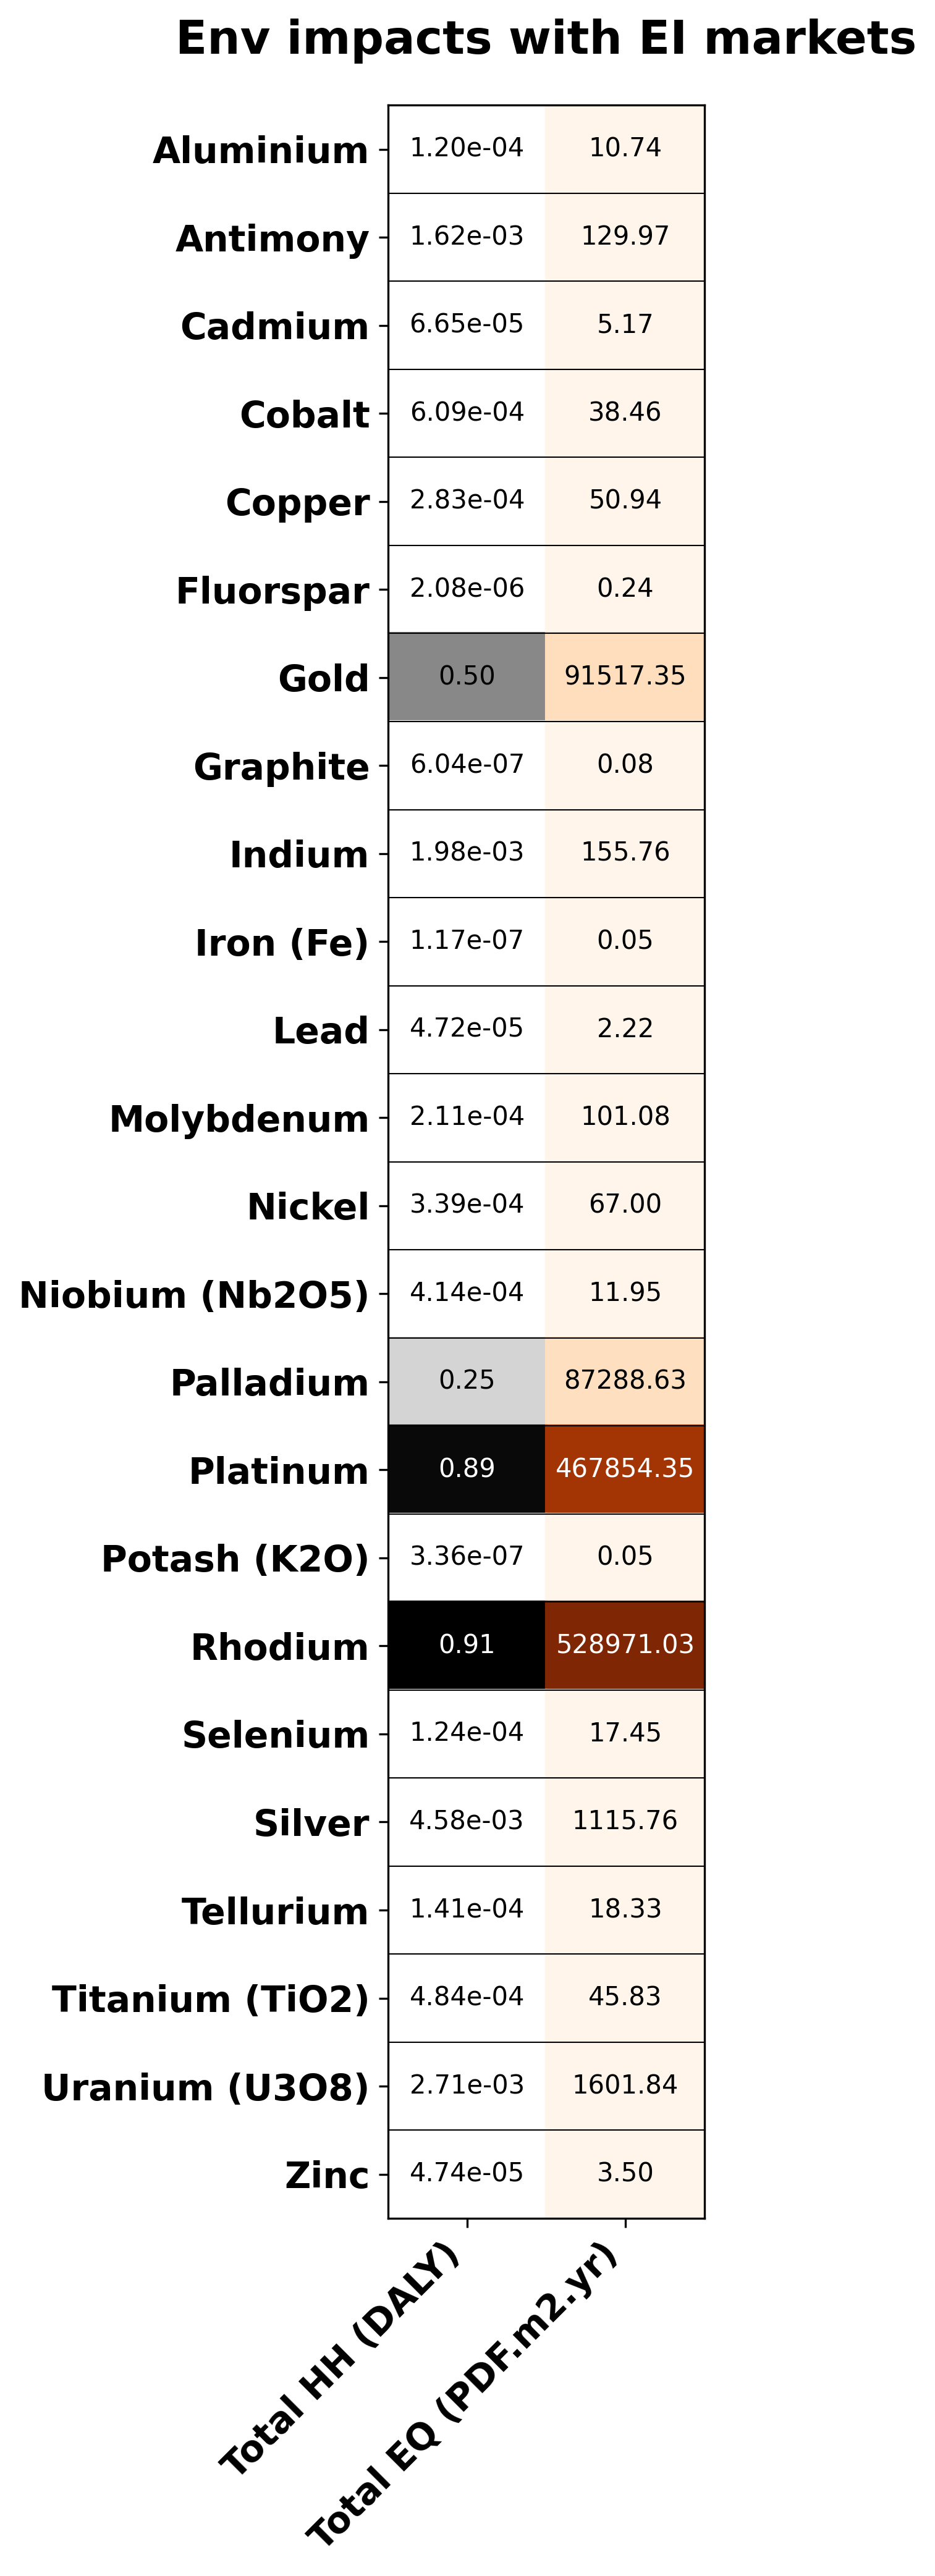

In [43]:
heatmap_lca(specific_lca_ei, 
            title='Env impacts with EI markets', 
            save_path='results/production_impacts_2023/env_impacts_market_ei.png')


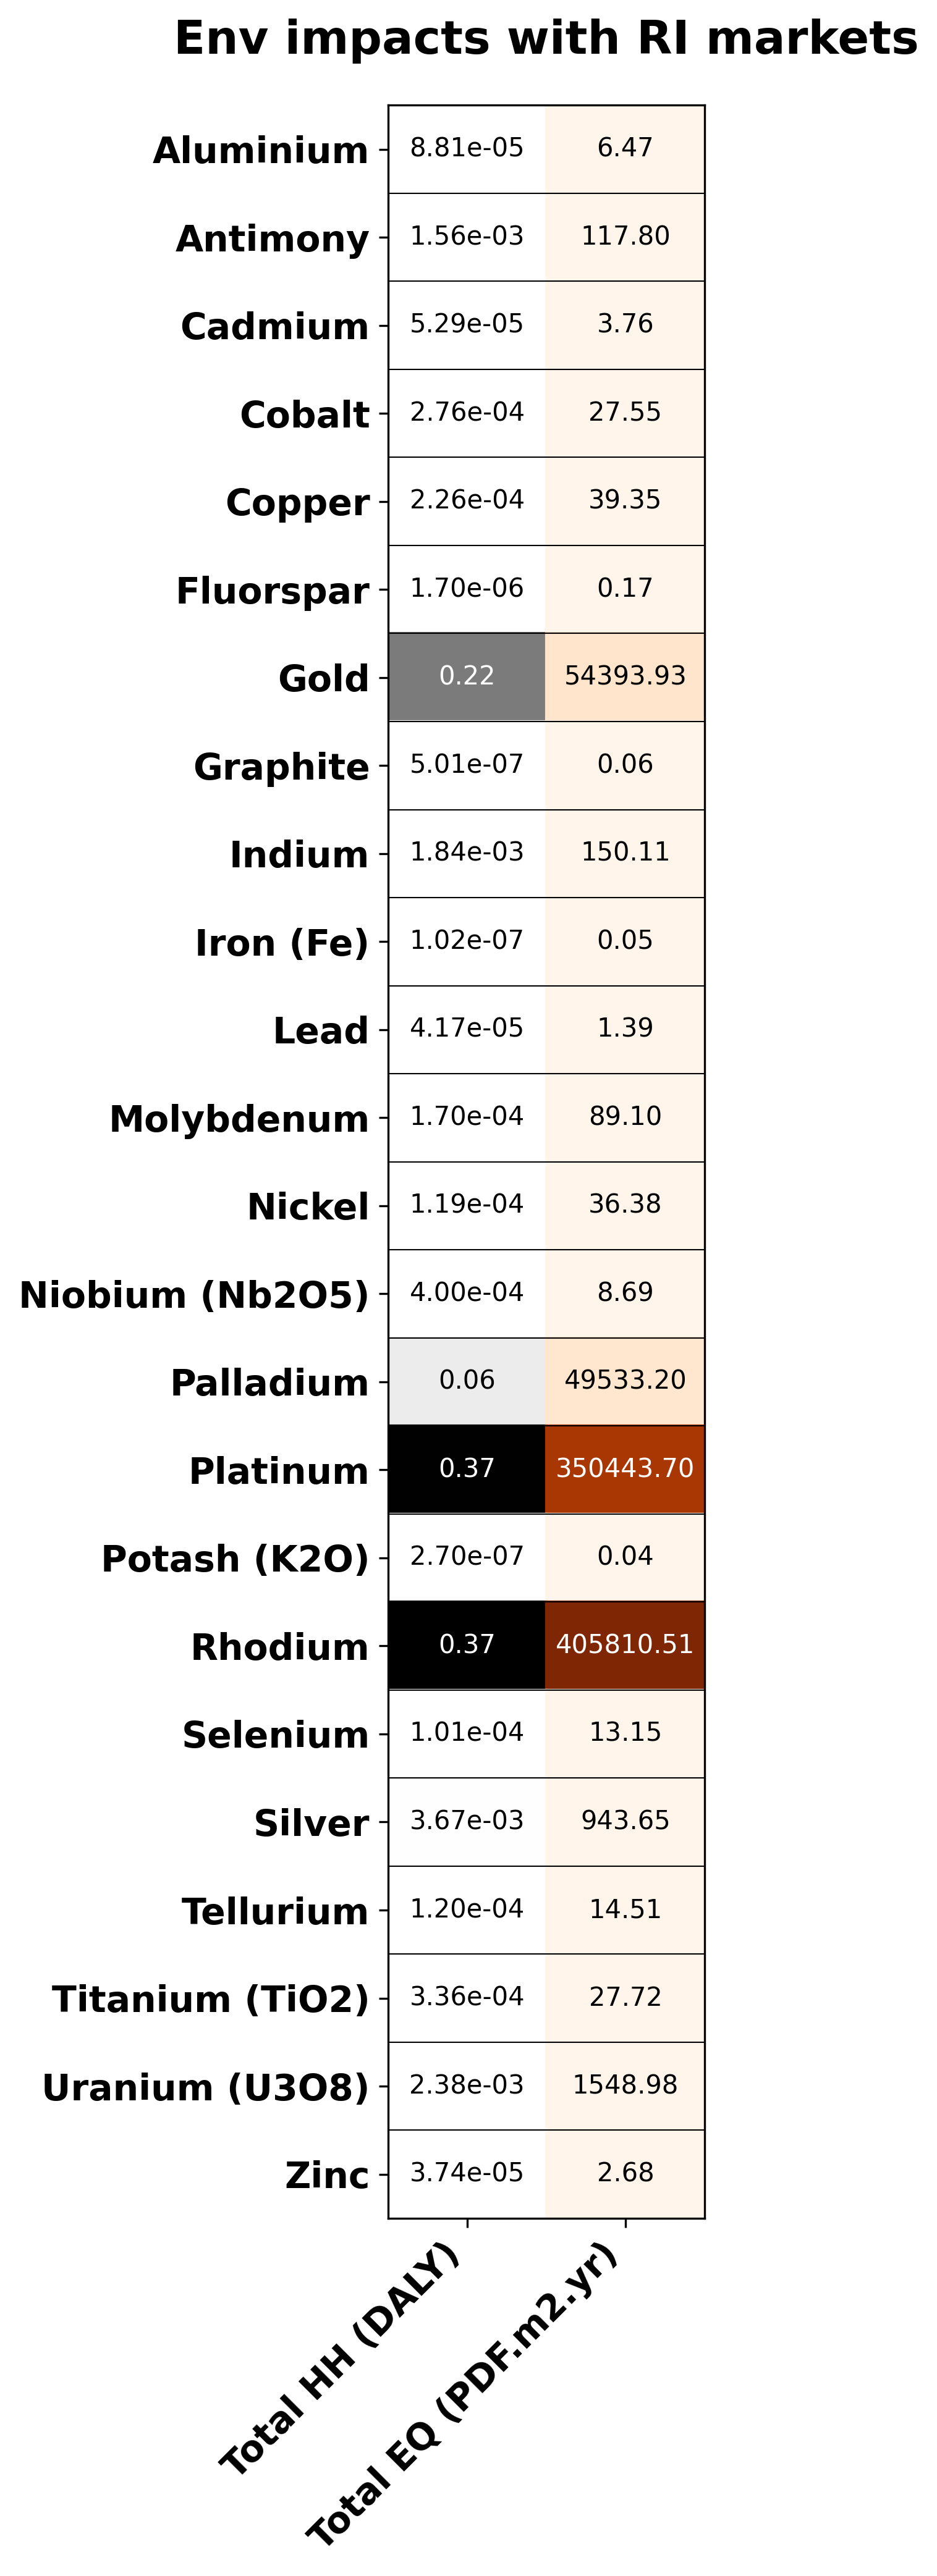

In [49]:
heatmap_lca(specific_lca_ri, 
            title='Env impacts with RI markets', 
            save_path='results/production_impacts_2023/env_impacts_markets_ri.png')

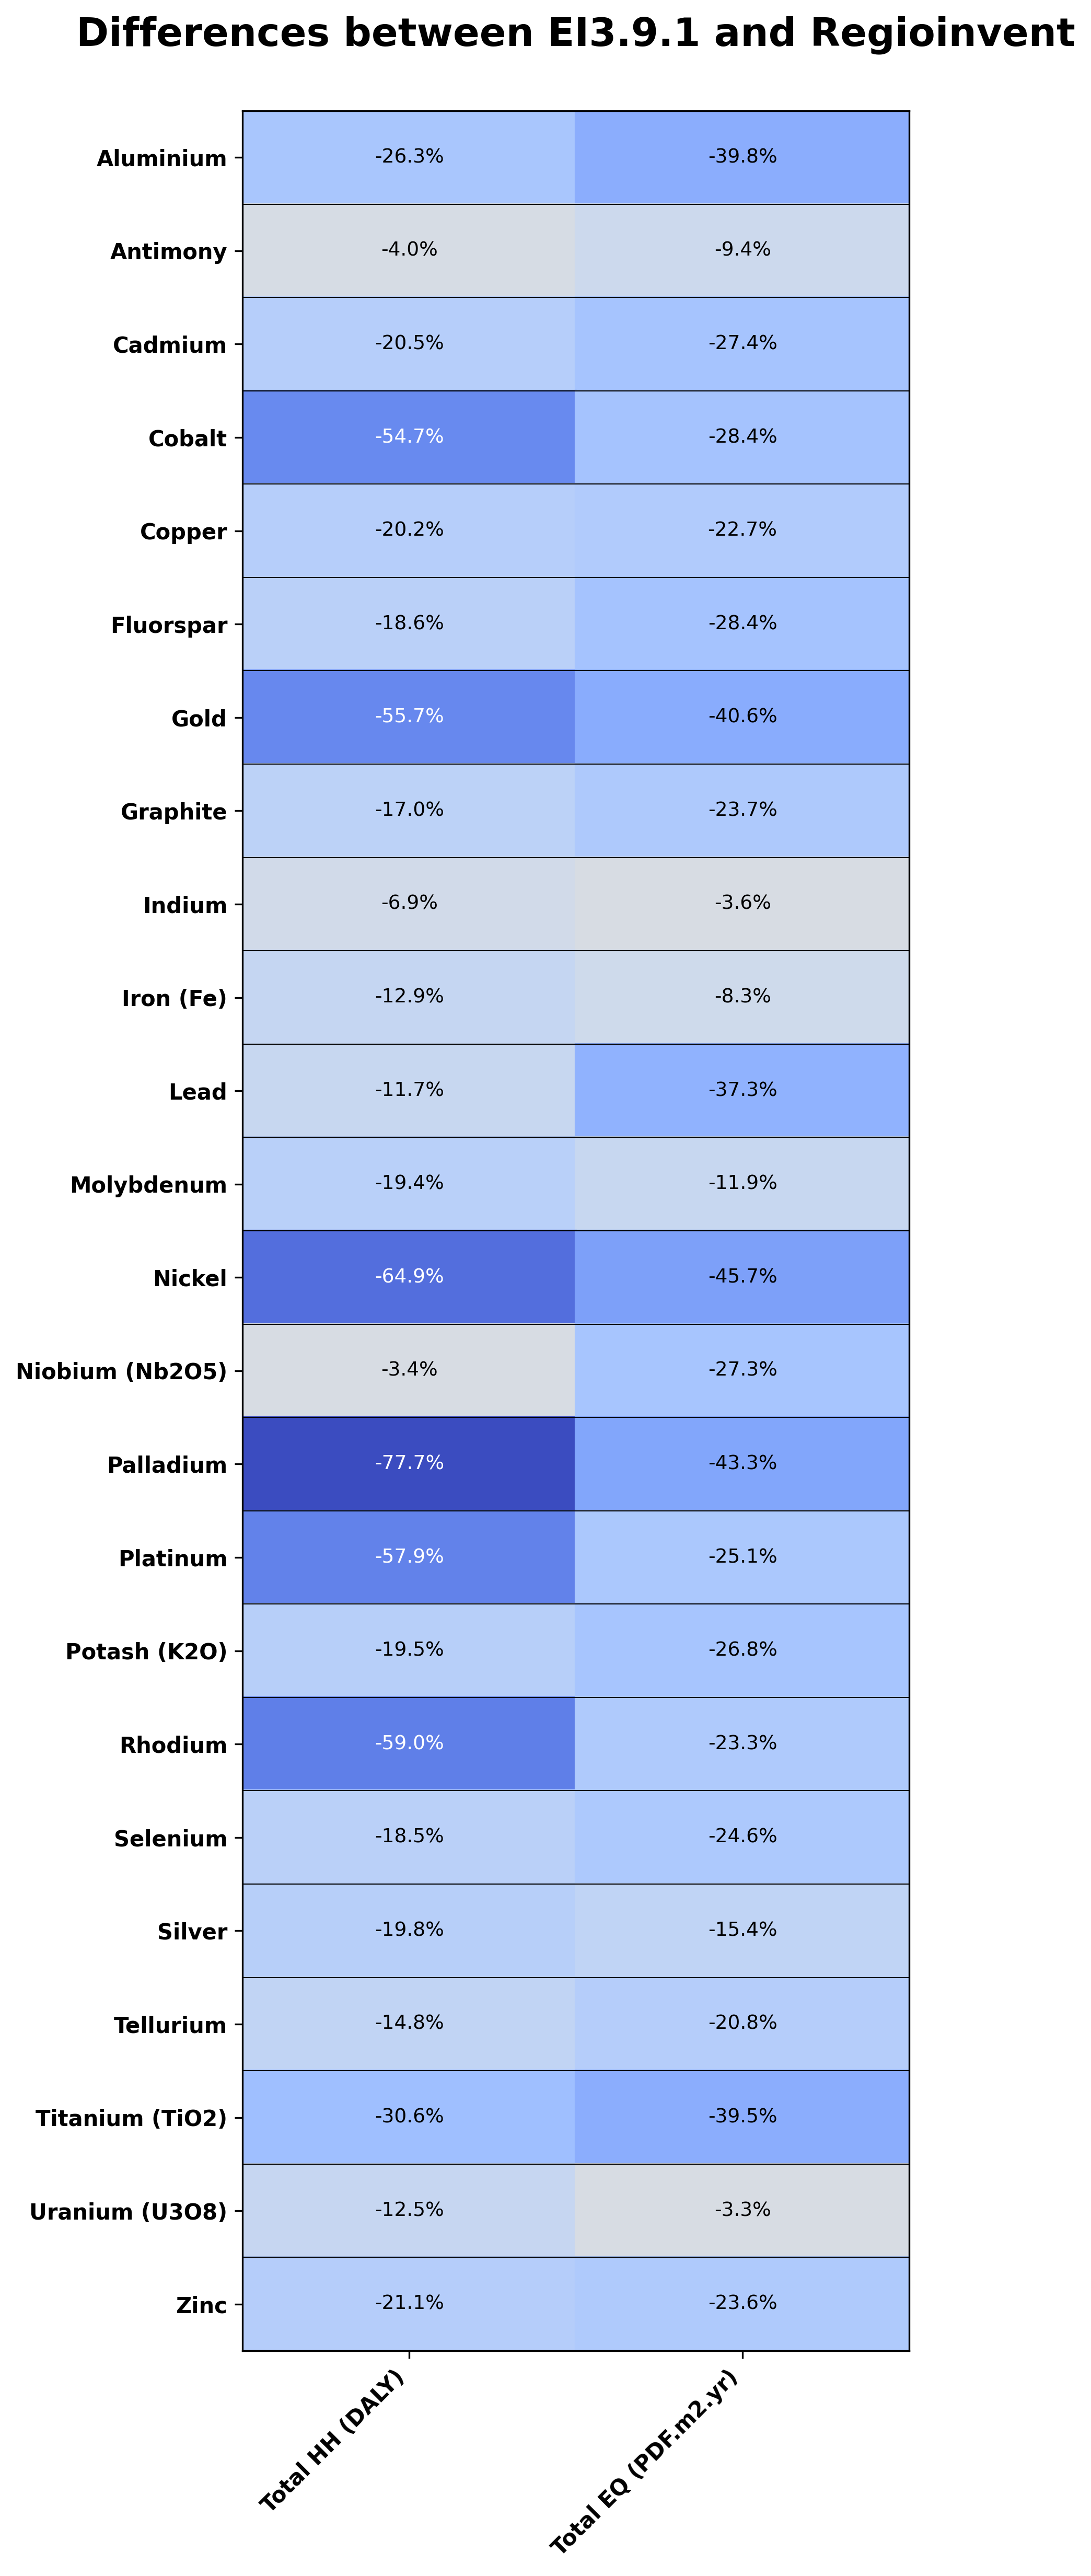

In [54]:
heatmap_db_comparison(specific_lca_ei, 
                      specific_lca_ri, 
                    title="Differences between EI3.9.1 and Regioinvent", 
                    save_path='results/production_impacts_2023/differences_ei_ri.png')


# Scale Regioinvent with 2023 production 

In [48]:
# We make sure we have the same number of commodities
canada_production_df_kg["Commodity"].nunique() == specific_lca_ri['Commodity'].nunique()

True

In [49]:
df_2023 = pd.merge(canada_production_df_kg, specific_lca_ri, left_on='Commodity', right_on='Commodity')

In [50]:
df_2023

,Commodity,Production Volume (kg),World Share (%),GWP100 (kg CO2-Eq),Total HH (DALY),Total EQ (PDF.m2.yr)
0,Aluminium,3.033966e+09,4.408193,9.244223,8.812850e-05,6.467515
1,Antimony,2.000000e+03,0.002409,18.974846,1.557415e-03,117.803760
2,Cadmium,1.800000e+06,7.825066,2.933341,5.290003e-05,3.756599
3,Cobalt,3.063000e+06,1.844847,30.072037,2.760007e-04,27.551156
4,Copper,5.107820e+08,2.298189,4.858826,2.259348e-04,39.353087
5,Fluorspar,2.000000e+07,0.216534,0.184595,1.695986e-06,0.174069
6,Gold,2.058310e+05,6.193863,21949.381907,2.228585e-01,54393.928651
7,Graphite,1.300000e+07,0.752539,0.064657,5.011719e-07,0.060841
8,Indium,3.900000e+04,3.869048,122.242985,1.842247e-03,150.107207
9,Iron (Fe),4.207390e+10,2.718035,0.007889,1.021994e-07,0.048692


In [51]:
# Multiply the production volume by each impact category column
impact_columns = ['GWP100 (kg CO2-Eq)', 'Total HH (DALY)', 'Total EQ (PDF.m2.yr)']  # Replace these with actual column names in your impact DataFrame
for col in impact_columns:
    df_2023[f'{col} Impact'] = df_2023['Production Volume (kg)'] * df_2023[col]
df_2023.columns

Index(['Commodity', 'Production Volume (kg)', 'World Share (%)',
       'GWP100 (kg CO2-Eq)', 'Total HH (DALY)', 'Total EQ (PDF.m2.yr)',
       'GWP100 (kg CO2-Eq) Impact', 'Total HH (DALY) Impact',
       'Total EQ (PDF.m2.yr) Impact'],
      dtype='object')

In [52]:
df_2023

,Commodity,Production Volume (kg),World Share (%),GWP100 (kg CO2-Eq),Total HH (DALY),Total EQ (PDF.m2.yr),GWP100 (kg CO2-Eq) Impact,Total HH (DALY) Impact,Total EQ (PDF.m2.yr) Impact
0,Aluminium,3.033966e+09,4.408193,9.244223,8.812850e-05,6.467515,2.804666e+10,267378.873211,1.962222e+10
1,Antimony,2.000000e+03,0.002409,18.974846,1.557415e-03,117.803760,3.794969e+04,3.114829,2.356075e+05
2,Cadmium,1.800000e+06,7.825066,2.933341,5.290003e-05,3.756599,5.280014e+06,95.220049,6.761878e+06
3,Cobalt,3.063000e+06,1.844847,30.072037,2.760007e-04,27.551156,9.211065e+07,845.390252,8.438919e+07
4,Copper,5.107820e+08,2.298189,4.858826,2.259348e-04,39.353087,2.481801e+09,115403.430248,2.010085e+10
5,Fluorspar,2.000000e+07,0.216534,0.184595,1.695986e-06,0.174069,3.691907e+06,33.919712,3.481382e+06
6,Gold,2.058310e+05,6.193863,21949.381907,2.228585e-01,54393.928651,4.517863e+09,45871.183772,1.119596e+10
7,Graphite,1.300000e+07,0.752539,0.064657,5.011719e-07,0.060841,8.405386e+05,6.515235,7.909353e+05
8,Indium,3.900000e+04,3.869048,122.242985,1.842247e-03,150.107207,4.767476e+06,71.847641,5.854181e+06
9,Iron (Fe),4.207390e+10,2.718035,0.007889,1.021994e-07,0.048692,3.319161e+08,4299.927729,2.048683e+09


In [53]:
# Resulting DataFrame contains original production volume and multiplied impacts
df_2023_result = df_2023[[ 'Commodity', 'Production Volume (kg)', 'World Share (%)', 
                           'GWP100 (kg CO2-Eq) Impact',
                            'Total HH (DALY) Impact',
                            'Total EQ (PDF.m2.yr) Impact']]

In [54]:
df_2023_result

,Commodity,Production Volume (kg),World Share (%),GWP100 (kg CO2-Eq) Impact,Total HH (DALY) Impact,Total EQ (PDF.m2.yr) Impact
0,Aluminium,3.033966e+09,4.408193,2.804666e+10,267378.873211,1.962222e+10
1,Antimony,2.000000e+03,0.002409,3.794969e+04,3.114829,2.356075e+05
2,Cadmium,1.800000e+06,7.825066,5.280014e+06,95.220049,6.761878e+06
3,Cobalt,3.063000e+06,1.844847,9.211065e+07,845.390252,8.438919e+07
4,Copper,5.107820e+08,2.298189,2.481801e+09,115403.430248,2.010085e+10
5,Fluorspar,2.000000e+07,0.216534,3.691907e+06,33.919712,3.481382e+06
6,Gold,2.058310e+05,6.193863,4.517863e+09,45871.183772,1.119596e+10
7,Graphite,1.300000e+07,0.752539,8.405386e+05,6.515235,7.909353e+05
8,Indium,3.900000e+04,3.869048,4.767476e+06,71.847641,5.854181e+06
9,Iron (Fe),4.207390e+10,2.718035,3.319161e+08,4299.927729,2.048683e+09


In [55]:
df_2023_result.to_csv('results/production_impacts_2023/env_impacts_2023.csv', index=False)

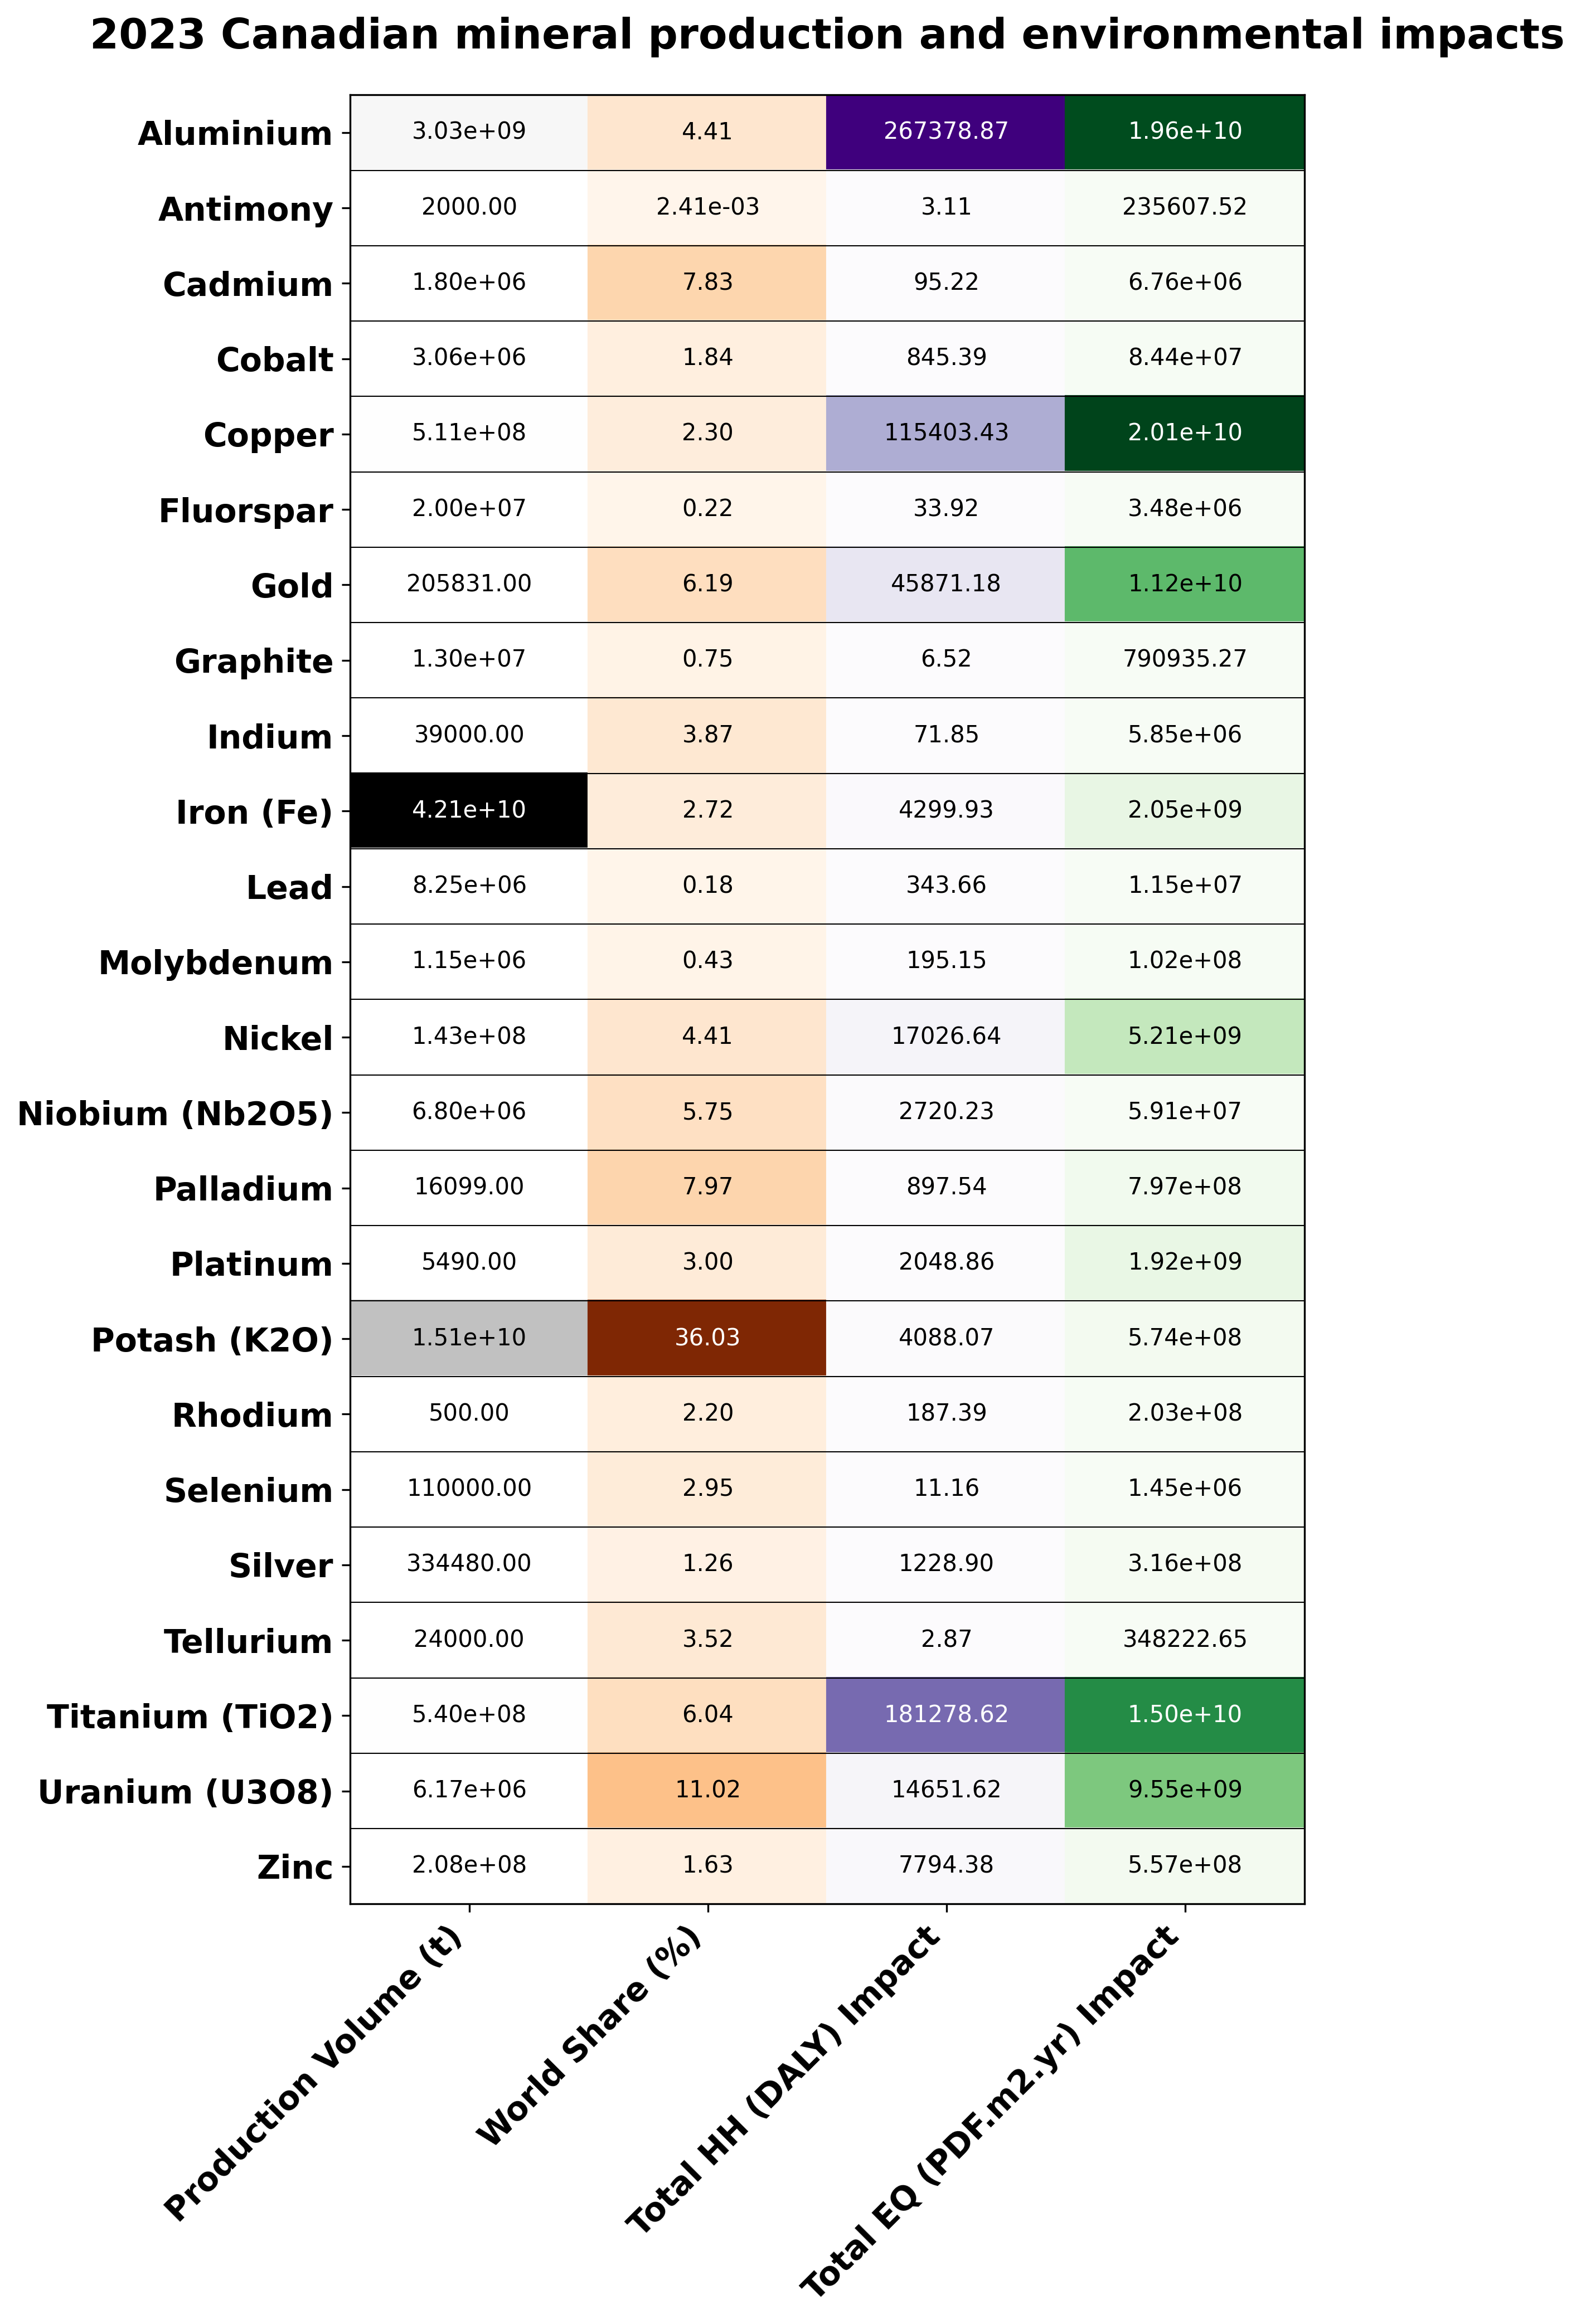

In [83]:
heatmap_lca(df_2023_result,
            title = '2023 Canadian mineral production and environmental impacts',
            save_path='results/production_impacts_2023/canada_2023_production_impacts_regioinvent.png')